In [1]:
import openai
from tqdm import tqdm
import re
import time
import json
from concurrent.futures import ThreadPoolExecutor

api_4 = 
model_4 = 'gpt-4-turbo-2024-04-09'
model_4v = "gpt-4-vision-preview"
model_3 = "gpt-3.5-turbo-0125"

client = openai.OpenAI(
    api_key=api_4,
)

history = []
message_history = []

system1 = "You are a penalty kicker taking a penalty shootout. There are two options for the direction of your kick, LEFT or RIGHT."
system2 = "You are a goalie taking a penalty shootout. You have two options for the direction of your goalkeeping, LEFT or RIGHT."


In [2]:
def response(system, prompt):
    max_attempts = 5
    attempt = 0
    while attempt < max_attempts:
        try:
            completion = client.chat.completions.create(
                model=model_3,
                messages=[
                    {"role": "system", "content": system},
                    {"role": "user", "content": prompt}
                ],
                temperature=1.0,
            )
            break  # If the operation is successful, exit the loop
        except Exception as e:
            print(f"An error occurred: {e}. Retrying in 5 seconds...")
            time.sleep(10)  # Wait for 5 seconds before retrying
            attempt += 1
            if attempt == max_attempts:
                return Exception

    return completion.choices[0].message.content

def find_action_content(s):
    # This regular expression matches '\\ACTION{' followed by any characters that are not '}'
    # until it encounters a '}', capturing the content inside the braces.
    matches = re.findall(r'ACTION{([^}]*)}', s)
    if matches:
        return matches[0]
    else:
        return False
    
def win(a, b):
    if a=='LEFT' and b=='LEFT':
        return "Goalie"
    elif a=='LEFT' and b=='RIGHT':
        return "Kicker"
    elif a=='RIGHT' and b=='RIGHT':
        return "Goalie"
    elif a=='RIGHT' and b=='LEFT':
        return "Kicker"
    else:
        return False

In [3]:
a1 = """
Here is the record of past meetings between you and the goalie in penalty shootouts.
Here is your past experiences: [
"""
a2 = """
Here is the record of past meetings between you and the kicker in penalty shootouts.
Here is your past experiences: [
"""
b = """
]
Directly give your choice in \\ACTION{...}, either LEFT or RIGHT. NO any other words are allowed.
#There is two examples of your output format:
'\\ACTION{RIGHT}'
'\\ACTION{LEFT}'
"""

In [8]:
for i in range(1):
    #Put history results in prompts
    if history:
        str_his = '\n'.join(str(d) for d in history)
        prompt1 = a1 + str_his + b
        prompt2 = a2 + str_his + b
    else:
        prompt1 = a1 + "    None," + b
        prompt2 = a2 + "    None," + b

    #Parallelizing API calls of two agents
    with ThreadPoolExecutor(max_workers=2) as executor:
        future1 = executor.submit(response, system1, prompt1)
        future2 = executor.submit(response, system2, prompt2)
        answer1 = future1.result()  # Wait for the first API response
        answer2 = future2.result()
    
    message_history.append({"Kicker": answer1})
    message_history.append({"Goalie": answer2})
    action1 = find_action_content(answer1)
    action2 = find_action_content(answer2)

    winner = win(action1, action2)
    #Cancel this turn if format error
    if winner!=False:
        new_his = {
        "Kicker": action1,
        "Goalie": action2,
        "Winner": winner
        }
        message_history.append(new_his)
        history.append(new_his)
        print(new_his)
    else:
        print("Error!" + answer1 + "\n" + answer2)
    
    if (i+1)%10==0:
        with open('game_record_history6.json', 'w') as f:
            json.dump(history, f, indent=4)
        with open('game_record6.json', 'w') as f:
            json.dump(message_history, f, indent=4)
        print("Data successfully saved.")

{'Kicker': 'LEFT', 'Goalie': 'LEFT', 'Winner': 'Goalie'}


In [10]:
# Specify the file name
file_name = 'game_record_history6.json'

# Writing the data to a JSON file
with open(file_name, 'w') as file:
    json.dump(history, file, indent=4)

print(f"Data successfully saved to {file_name}.")

Data successfully saved to game_record_history6.json.


In [2]:
import json
import matplotlib.pyplot as plt

# Load the data from the JSON file
with open("game_record_history6.json", "r") as file:
    data = json.load(file)

# Initialize counters
kicker_left = 0
kicker_right = 0
goalie_left = 0
goalie_right = 0

# Count occurrences
for record in data:
    if record["Kicker"] == "LEFT":
        kicker_left += 1
    elif record["Kicker"] == "RIGHT":
        kicker_right += 1

    if record["Goalie"] == "LEFT":
        goalie_left += 1
    elif record["Goalie"] == "RIGHT":
        goalie_right += 1

kicker_left, kicker_right, goalie_left, goalie_right, len(data)


(49, 51, 45, 55, 100)

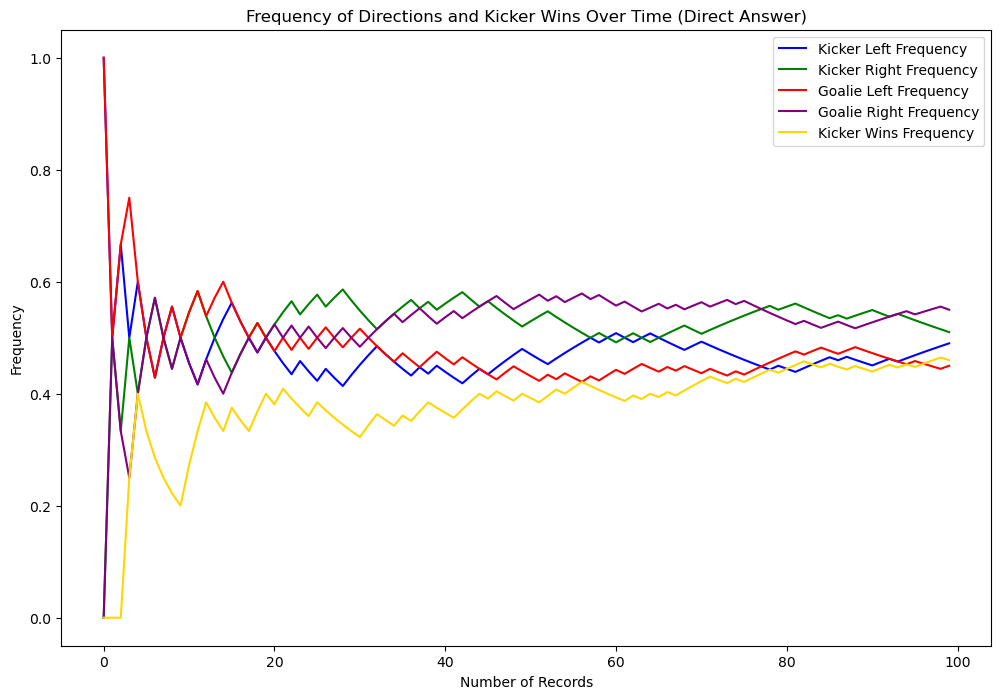

In [4]:
# Initialize counters and lists to track frequency over time
kicker_left_freq = []
kicker_right_freq = []
goalie_left_freq = []
goalie_right_freq = []

# Initialize counters and lists to track kicker winning frequency over time
kicker_wins_freq = []
kicker_wins_count = 0

kicker_left_count = 0
kicker_right_count = 0
goalie_left_count = 0
goalie_right_count = 0
total_records = 0

# Calculate frequency at each record
for record in data:
    total_records += 1
    if record["Kicker"] == "LEFT":
        kicker_left_count += 1
    elif record["Kicker"] == "RIGHT":
        kicker_right_count += 1

    if record["Goalie"] == "LEFT":
        goalie_left_count += 1
    elif record["Goalie"] == "RIGHT":
        goalie_right_count += 1

    if record["Winner"] == "Kicker":
        kicker_wins_count += 1
    
    # Append the frequency at this point
    kicker_wins_freq.append(kicker_wins_count / total_records)
    kicker_left_freq.append(kicker_left_count / total_records)
    kicker_right_freq.append(kicker_right_count / total_records)
    goalie_left_freq.append(goalie_left_count / total_records)
    goalie_right_freq.append(goalie_right_count / total_records)

# Plotting the frequencies over records with kicker winning frequency added
plt.figure(figsize=(12, 8))
plt.plot(kicker_left_freq, label='Kicker Left Frequency', color='blue')
plt.plot(kicker_right_freq, label='Kicker Right Frequency', color='green')
plt.plot(goalie_left_freq, label='Goalie Left Frequency', color='red')
plt.plot(goalie_right_freq, label='Goalie Right Frequency', color='purple')
plt.plot(kicker_wins_freq, label='Kicker Wins Frequency', color='gold')
plt.xlabel('Number of Records')
plt.ylabel('Frequency')
plt.title('Frequency of Directions and Kicker Wins Over Time (Direct Answer)')
plt.legend()
plt.show()
